In [1]:
import torch, torch.nn as nn, torch.nn.functional as F, torch.optim as optim
import torchvision.transforms as T
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
import numpy as np, time, random, os
from collections import namedtuple
from sklearn.metrics import precision_score, f1_score
import matplotlib.pyplot as plt
from torchvision.models import ResNet18_Weights


In [2]:
import torch.nn as nn
import torchvision.models as models

def get_resnet18_scratch(num_classes: int = 10, freeze_backbone: bool = False):
    """
    Trả về ResNet-18 khởi tạo ngẫu nhiên (weights=None).
    - num_classes      : số lớp đầu ra.
    - freeze_backbone  : True → chỉ huấn luyện lớp FC cuối.
    """
    # 1. Tạo ResNet-18 khởi tạo ngẫu nhiên
    model = models.resnet18(weights=None)        # <-- KHÔNG tải trọng số cũ

    # 2. Thay thế fully-connected
    in_feats = model.fc.in_features
    model.fc = nn.Linear(in_feats, num_classes)

    # 3. (Tuỳ chọn) đóng băng backbone
    if freeze_backbone:
        for p in model.parameters():
            p.requires_grad = False
        for p in model.fc.parameters():          
            p.requires_grad = True

    return model


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = get_resnet18_scratch(
    num_classes=10,
    freeze_backbone=False   # huấn luyện toàn bộ mạng
).to(device)

In [4]:
STATE_DIM = 6                     # acc, loss, Δacc, Δloss, epoch%, prev_action
ACTION_DIM = 2                    # 0 = SGD, 1 = SAM

class PolicyNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(STATE_DIM, 64), nn.ReLU(),
            nn.Linear(64, 64), nn.ReLU(),
            nn.Linear(64, ACTION_DIM), nn.Softmax(dim=-1),
        )
    def forward(self, x): return self.net(x)

class ValueNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(STATE_DIM, 64), nn.ReLU(),
            nn.Linear(64, 64), nn.ReLU(),
            nn.Linear(64, 1),
        )
    def forward(self, x): return self.net(x)


In [5]:
class SAM(optim.Optimizer):
    """Sharpness-Aware Minimization wrapper (một bước trước + một bước sau)"""
    def __init__(self, params, base_optimizer, rho=0.05, **kwargs):
        defaults = dict(rho=rho, **kwargs)
        super().__init__(params, defaults)
        self.base_optimizer = base_optimizer(self.param_groups, **kwargs)
        self.param_groups = self.base_optimizer.param_groups

    @torch.no_grad()
    def first_step(self, zero_grad=False):
        grad_norm = torch.norm(torch.stack([
            p.grad.norm() for group in self.param_groups
            for p in group['params'] if p.grad is not None
        ]))
        scale = [group['rho'] / (grad_norm + 1e-12) for group in self.param_groups]
        for group, s in zip(self.param_groups, scale):
            for p in group['params']:
                if p.grad is None: continue
                e_w = p.grad * s.to(p)
                p.add_(e_w);  self.state[p]['e_w'] = e_w
        if zero_grad: self.zero_grad()

    @torch.no_grad()
    def second_step(self, zero_grad=False):
        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None: continue
                p.sub_(self.state[p]['e_w'])
        self.base_optimizer.step()
        if zero_grad: self.zero_grad()

In [6]:
Transition = namedtuple('Transition', ['state','action','logp_old','reward','value','entropy'])

def gae_returns(trans, gamma=0.99, lam=0.95):
    rewards  = [t.reward for t in trans]
    values   = [t.value  for t in trans] + [0.0]
    returns, advs = [], []
    gae = 0
    for i in reversed(range(len(trans))):
        delta = rewards[i] + gamma*values[i+1] - values[i]
        gae   = delta + gamma*lam*gae
        advs.insert(0, gae)
        returns.insert(0, gae + values[i])
    advs = torch.tensor(advs,  dtype=torch.float32)
    advs = (advs - advs.mean()) / (advs.std() + 1e-8)
    returns = torch.tensor(returns, dtype=torch.float32)
    return returns, advs

100%|██████████| 26.4M/26.4M [00:01<00:00, 16.5MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 303kB/s]
100%|██████████| 4.42M/4.42M [00:00<00:00, 5.60MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 27.4MB/s]


Dataset → Train: 55000 | Val: 5000 | Test: 10000
Ep 0   | Roll 1: Act=SAM | Rwd= +8.03 | Time=19.90s | Train L=0.6140, Acc=78.42% | Val L=0.3969, Acc=84.74%
Ep 0   | Roll 2: Act=SGD | Rwd= +0.36 | Time=11.91s | Train L=0.4183, Acc=84.84% | Val L=0.3172, Acc=88.02%
Ep 0   | Roll 3: Act=SGD | Rwd= +0.13 | Time=12.36s | Train L=0.3153, Acc=88.27% | Val L=0.2921, Acc=89.10%
Ep 0   | Roll 4: Act=SAM | Rwd= +0.14 | Time=19.65s | Train L=0.2367, Acc=91.39% | Val L=0.2478, Acc=90.56%
[Ep   0] TrainAcc=0.9139 | ValAcc=0.9056 | TestAcc=0.9002 | MeanRwd=+2.16 | Opt=SAM | Δt=65.7s
Ep 1   | Roll 1: Act=SGD | Rwd= -0.13 | Time=12.30s | Train L=0.2570, Acc=90.42% | Val L=0.2692, Acc=90.00%
Ep 1   | Roll 2: Act=SAM | Rwd= +0.11 | Time=19.16s | Train L=0.2049, Acc=92.52% | Val L=0.2289, Acc=91.18%
Ep 1   | Roll 3: Act=SAM | Rwd= -0.00 | Time=19.08s | Train L=0.1907, Acc=93.13% | Val L=0.2257, Acc=91.14%
Ep 1   | Roll 4: Act=SAM | Rwd= +0.06 | Time=19.18s | Train L=0.1845, Acc=93.37% | Val L=0.2203, Acc

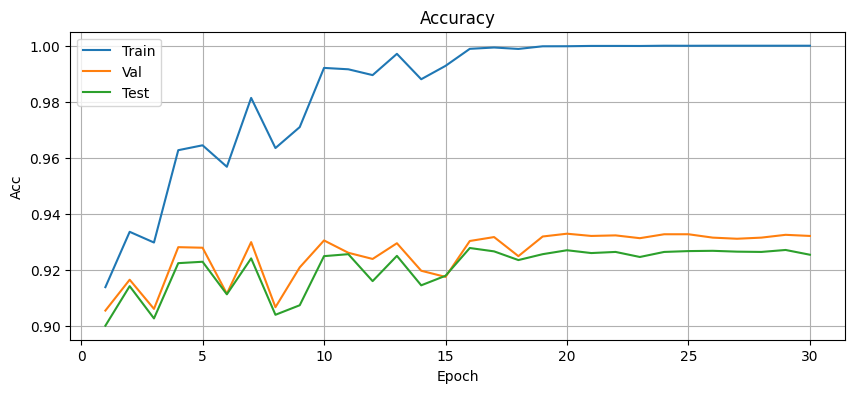

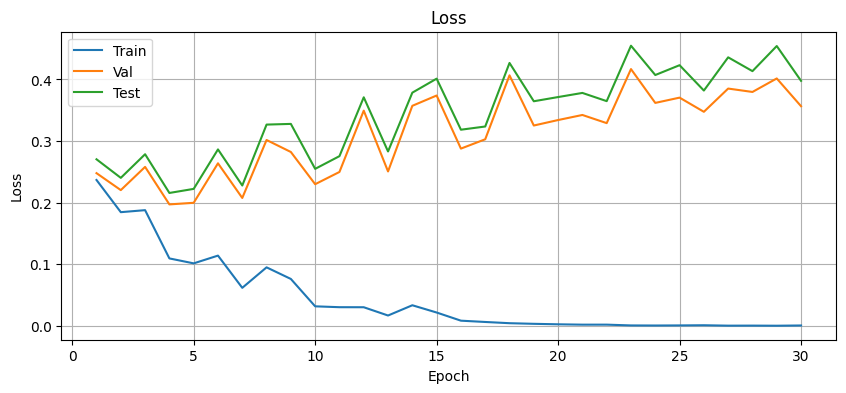


===== FINAL TEST METRICS =====
Accuracy : 0.9255
F1 score : 0.9253
Precision: 0.9253


In [7]:
from torchvision.datasets import FashionMNIST
import torchvision.transforms as T
from torch.utils.data import DataLoader, random_split
import torch, torch.nn.functional as F, time, numpy as np
from sklearn.metrics import accuracy_score, f1_score, precision_score
import matplotlib.pyplot as plt
import torchvision.models as models

def train():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Transforms cho FashionMNIST
    tf_train = T.Compose([
        T.Resize(32),
        T.RandomHorizontalFlip(),
        T.ToTensor(),
        T.Lambda(lambda x: x.repeat(3, 1, 1)),
        T.Normalize((0.2860, 0.2860, 0.2860),
                    (0.3530, 0.3530, 0.3530)),
    ])
    tf_eval = T.Compose([
        T.Resize(32),
        T.ToTensor(),
        T.Lambda(lambda x: x.repeat(3, 1, 1)),
        T.Normalize((0.2860, 0.2860, 0.2860),
                    (0.3530, 0.3530, 0.3530)),
    ])

    # Dataset
    full_train = FashionMNIST(root='./data', train=True, download=True, transform=tf_train)
    test_set   = FashionMNIST(root='./data', train=False, download=True, transform=tf_eval)

    n_val = 5_000
    train_ds, val_ds = random_split(full_train, [len(full_train) - n_val, n_val])

    dl_train = DataLoader(train_ds, batch_size=128, shuffle=True, num_workers=2, pin_memory=True)
    dl_val   = DataLoader(val_ds,   batch_size=256, shuffle=False, num_workers=2, pin_memory=True)
    dl_test  = DataLoader(test_set, batch_size=256, shuffle=False, num_workers=2, pin_memory=True)

    print(f"Dataset → Train: {len(train_ds)} | Val: {len(val_ds)} | Test: {len(test_set)}")

    # Model & PPO nets
    policy_net  = PolicyNet().to(device)
    value_net   = ValueNet().to(device)
    opt_policy  = torch.optim.Adam(policy_net.parameters(), lr=3e-4)
    opt_value   = torch.optim.Adam(value_net.parameters(),  lr=1e-3)

    eps_clip, ent_coef, vf_coef = 0.2, 1e-2, 0.5
    num_epochs, rollouts_per_ep, ppo_epochs = 100, 4, 4
    best_val, patience, patience_cnt = 0, 10, 0

    history = {k: [] for k in
               ['train_acc', 'train_loss', 'val_acc', 'val_loss',
                'test_acc', 'test_loss', 'reward', 'action']}

    # Khởi tạo các biến theo dõi
    prev_acc = prev_loss = 0.0
    prev_val_acc = prev_val_loss = 0.0
    prev_act = 0  # 0=SGD, 1=SAM

    # Hàm đánh giá nhanh ----------------------------------------------------
    def eval_loader(loader):
        model.eval()
        tot_loss = correct = total = 0
        with torch.no_grad():
            for x, y in loader:
                x, y = x.to(device), y.to(device)
                logits = model(x)
                loss   = F.cross_entropy(logits, y)
                tot_loss += loss.item() * x.size(0)
                correct  += logits.argmax(1).eq(y).sum().item()
                total    += x.size(0)
        return correct / total, tot_loss / total

    #  Epoch loop ---------------------------------------------------------
    for ep in range(num_epochs):
        t_ep = time.time()
        buffer = []

        for r in range(rollouts_per_ep):
            t_roll = time.time()

            # ---- build state ------------------------------------------------
            delta_acc  = prev_acc      - history['train_acc'][-1] if history['train_acc'] else 0.0
            delta_loss = prev_loss     - prev_loss               # =0 lần đầu
            state_arr  = [prev_acc, prev_loss, delta_acc, delta_loss,
                          ep / num_epochs, float(prev_act)]
            state = torch.tensor(state_arr, dtype=torch.float32, device=device)

            # ---- choose action ---------------------------------------------
            with torch.no_grad():
                dist = policy_net(state)
            act = torch.distributions.Categorical(dist).sample()
            logp_old = torch.log(dist[act])
            entropy  = -(dist * torch.log(dist + 1e-8)).sum()

            # ---- pick optimizer -------------------------------------------
            if act.item() == 0:  # SGD
                opt_base = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
                two_step = False
            else:                # SAM
                opt_base = SAM(model.parameters(), torch.optim.SGD, lr=0.001, momentum=0.9)
                two_step = True

            # ---- train one pass -------------------------------------------
            model.train()
            tot_loss = correct = total = 0
            for x, y in dl_train:
                x, y = x.to(device), y.to(device)
                opt_base.zero_grad()

                logits = model(x)
                loss   = F.cross_entropy(logits, y)
                loss.backward()

                if two_step:
                    opt_base.first_step(zero_grad=True)

                    # forward + backward lần 2
                    logits2 = model(x)
                    loss2 = F.cross_entropy(logits2, y)
                    loss2.backward()
                    opt_base.second_step()
                else:
                    opt_base.step()

                tot_loss += loss.item() * x.size(0)
                correct  += logits.argmax(1).eq(y).sum().item()
                total    += x.size(0)

            train_acc  = correct / total
            train_loss = tot_loss / total

            # ---- validation ngay sau train ---------------------------------F
            val_acc, val_loss = eval_loader(dl_val)

            # ---- reward (dựa validation) ----------------------------------
            delta_vacc  = val_acc  - prev_val_acc
            delta_vloss = prev_val_loss - val_loss  # giảm loss => dương
            raw_reward  = 10 * delta_vacc + delta_vloss - 0.05 * (act.item() != prev_act)
            reward      = float(torch.clamp(torch.tensor(raw_reward), -10.0, 10.0))

            # ---- lưu transition -------------------------------------------
            value = value_net(state).item()
            buffer.append(Transition(state, act, logp_old, reward, value, entropy))

            # ---- cập nhật "prev" ------------------------------------------
            prev_acc, prev_loss, prev_act = train_acc, train_loss, act.item()
            prev_val_acc, prev_val_loss   = val_acc,  val_loss

            # ---- log rollout ----------------------------------------------
            print(f"Ep {ep:<3} | Roll {r+1}: "
                  f"Act={'SAM' if act.item() else 'SGD'} | "
                  f"Rwd={reward:+6.2f} | "
                  f"Time={time.time()-t_roll:5.2f}s | "
                  f"Train L={train_loss:.4f}, Acc={train_acc*100:5.2f}% | "
                  f"Val L={val_loss:.4f}, Acc={val_acc*100:5.2f}%")

        # ----- PPO update ---------------------------------------------------
        returns, advs = gae_returns(buffer)
        returns, advs = returns.to(device), advs.to(device)

        S   = torch.stack([t.state   for t in buffer]).to(device)
        A   = torch.tensor([t.action.item() for t in buffer],
                           dtype=torch.long, device=device)
        logp_old = torch.stack([t.logp_old for t in buffer]).to(device)
        Ent      = torch.stack([t.entropy  for t in buffer]).to(device)

        for _ in range(ppo_epochs):
            dist = policy_net(S)
            logp = torch.log(dist.gather(1, A.unsqueeze(1)).squeeze(1) + 1e-8)
            ratio = torch.exp(logp - logp_old)

            surr1 = ratio * advs
            surr2 = torch.clamp(ratio, 1 - eps_clip, 1 + eps_clip) * advs
            policy_loss = -torch.min(surr1, surr2).mean() - ent_coef * Ent.mean()

            value_pred  = value_net(S).squeeze(1)
            value_loss  = F.mse_loss(value_pred, returns)

            opt_policy.zero_grad(); policy_loss.backward(); opt_policy.step()
            opt_value.zero_grad();  (vf_coef * value_loss).backward(); opt_value.step()

        # ----- log cuối epoch ----------------------------------------------
        test_acc, test_loss = eval_loader(dl_test)

        history['train_acc'].append(train_acc);  history['train_loss'].append(train_loss)
        history['val_acc'].append(val_acc);      history['val_loss'].append(val_loss)
        history['test_acc'].append(test_acc);    history['test_loss'].append(test_loss)
        history['reward'].append(np.mean([t.reward for t in buffer]))
        history['action'].append(prev_act)

        print(f"[Ep {ep:3}] TrainAcc={train_acc:.4f} | ValAcc={val_acc:.4f} | "
              f"TestAcc={test_acc:.4f} | MeanRwd={history['reward'][-1]:+.2f} | "
              f"Opt={'SAM' if prev_act else 'SGD'} | Δt={time.time()-t_ep:.1f}s")

        # Early-stopping
        if val_acc > best_val:
            best_val, patience_cnt = val_acc, 0
        else:
            patience_cnt += 1
            if patience_cnt >= patience:
                print(f"Early-stop tại epoch {ep} – không cải thiện {patience} epoch.")
                break

    # 4️⃣ Plot --------------------------------------------------------------
    epochs = range(1, len(history['train_acc']) + 1)
    plt.figure(figsize=(10,4))
    plt.plot(epochs, history['train_acc'], label='Train')
    plt.plot(epochs, history['val_acc'],   label='Val')
    plt.plot(epochs, history['test_acc'],  label='Test')
    plt.title('Accuracy'); plt.xlabel('Epoch'); plt.ylabel('Acc'); plt.legend(); plt.grid(); plt.show()

    plt.figure(figsize=(10,4))
    plt.plot(epochs, history['train_loss'], label='Train')
    plt.plot(epochs, history['val_loss'],   label='Val')
    plt.plot(epochs, history['test_loss'],  label='Test')
    plt.title('Loss'); plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(); plt.grid(); plt.show()

    # 5️⃣ Final test metrics -------------------------------------------------
    model.eval(); preds_all, labels_all = [], []
    with torch.no_grad():
        for x, y in dl_test:
            x, y = x.to(device), y.to(device)
            preds_all.append(model(x).argmax(1).cpu())
            labels_all.append(y.cpu())
    preds_all  = torch.cat(preds_all)
    labels_all = torch.cat(labels_all)

    print("\n===== FINAL TEST METRICS =====")
    print(f"Accuracy : {accuracy_score(labels_all, preds_all):.4f}")
    print(f"F1 score : {f1_score(labels_all, preds_all, average='weighted'):.4f}")
    print(f"Precision: {precision_score(labels_all, preds_all, average='weighted'):.4f}")
if __name__ == '__main__':
    train() 